In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('../data/togo-dapaong_qc.csv')

In [3]:
print("Summary Statistics:")
print(df.describe())
print("Dataset Shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%         0

In [4]:
print("\nMissing Values:")
print(df.isna().sum())


Missing Values:
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


In [5]:
print("\nColumns with >5% Null:")
null_percent = (df.isna().sum() / len(df)) * 100
high_null_cols = null_percent[null_percent>5]
print(high_null_cols)


Columns with >5% Null:
Comments    100.0
dtype: float64


In [6]:
print("\n MISSING VALUES CHECK")
print("Missing values in key solar columns:")
print(f"GHI missing: {df['GHI'].isna().sum()}")
print(f"DNI missing: {df['DNI'].isna().sum()}")
print(f"DHI missing: {df['DHI'].isna().sum()}")


 MISSING VALUES CHECK
Missing values in key solar columns:
GHI missing: 0
DNI missing: 0
DHI missing: 0


In [7]:
specified_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

for col in specified_columns:
    if col in df.columns:
        missing_count = df[col].isna().sum()
        missing_percent = (missing_count / len(df)) * 100
        print(f"{col}: {missing_count} missing")
    else:
        print(f"{col}: Column not found in dataset")

GHI: 0 missing
DNI: 0 missing
DHI: 0 missing
ModA: 0 missing
ModB: 0 missing
WS: 0 missing
WSgust: 0 missing



VISUAL OUTLIER CHECK


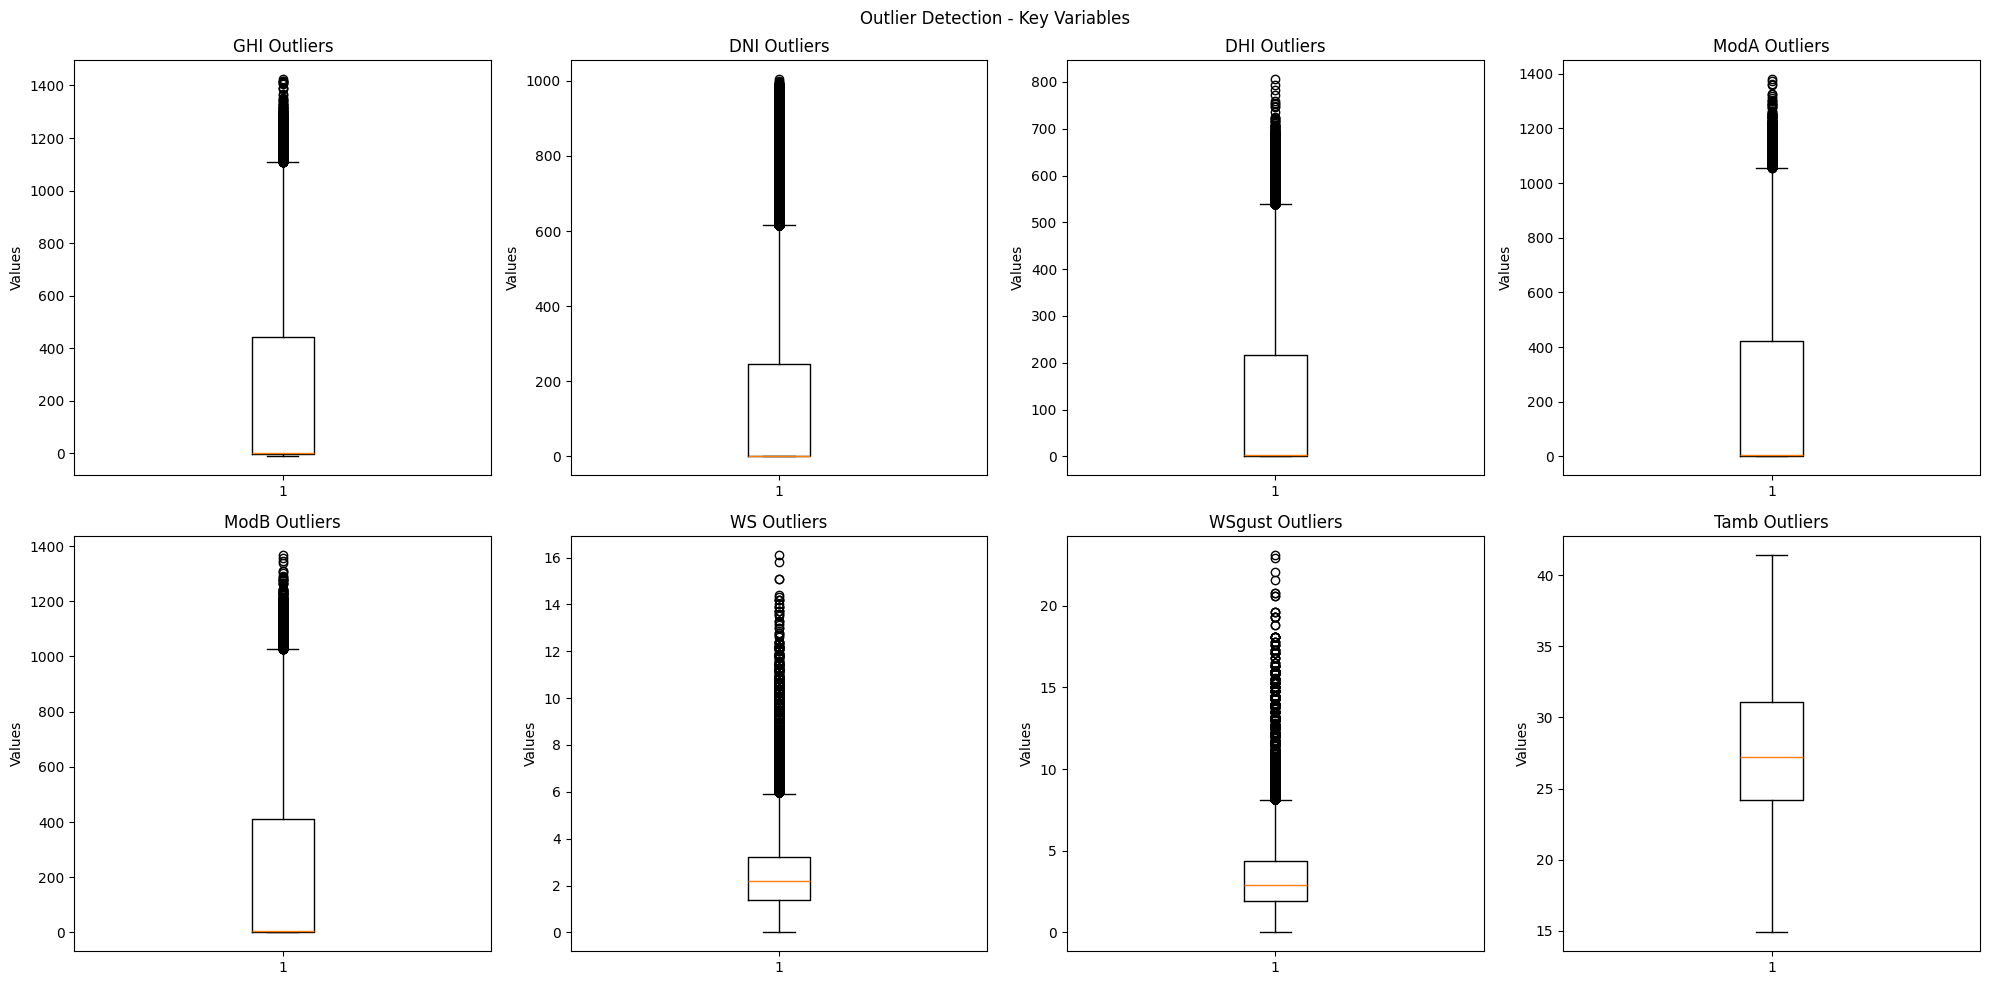

In [8]:
#  VISUAL OUTLIER CHECK for GHI, DNI, DHI, ModA, ModB, WS, WSgust
print("\nVISUAL OUTLIER CHECK")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Outlier Detection - Key Variables')

solar_cols = ['GHI', 'DNI', 'DHI', 'ModA']
sensor_cols = ['ModB', 'WS', 'WSgust', 'Tamb']

for i, col in enumerate(solar_cols):
    if col in df.columns:
        axes[0,i].boxplot(df[col].dropna())
        axes[0,i].set_title(f'{col} Outliers')
        axes[0,i].set_ylabel('Values')

for i, col in enumerate(sensor_cols):
    if col in df.columns:
        axes[1,i].boxplot(df[col].dropna())
        axes[1,i].set_title(f'{col} Outliers') 
        axes[1,i].set_ylabel('Values')

plt.tight_layout()
plt.show()

In [9]:
# CHECK FOR INCORRECT ENTRIES in GHI, DNI, DHI
print("INCORRECT ENTRIES CHECK")
print("Negative values")
print(f"GHI < 0: {(df['GHI'] < 0).sum()}")
print(f"DNI < 0: {(df['DNI'] < 0).sum()}") 
print(f"DHI < 0: {(df['DHI'] < 0).sum()}")

print("\nExtremely high values (potential errors):")
print(f"GHI > 1500 W/m²: {(df['GHI'] > 1500).sum()}")  
print(f"DNI > 1200 W/m²: {(df['DNI'] > 1200).sum()}")
print(f"DHI > 500 W/m²: {(df['DHI'] > 500).sum()}")

INCORRECT ENTRIES CHECK
Negative values
GHI < 0: 257385
DNI < 0: 0
DHI < 0: 0

Extremely high values (potential errors):
GHI > 1500 W/m²: 0
DNI > 1200 W/m²: 0
DHI > 500 W/m²: 13856


In [10]:
print("Z-SCORE OUTLIER DETECTION ")
outlier_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
available_cols = [col for col in outlier_columns if col in df.columns]

z_scores = np.abs(stats.zscore(df[available_cols].dropna()))
outlier_mask = (z_scores > 3).any(axis=1)

print(f"Rows with |Z| > 3 in any key column: {len(outlier_mask)}")
print(f"Percentage of outliers: {outlier_mask.sum()/len(df)*100:.2f}%")
print("Row indices:", np.unique(outlier_mask))

print("  Outliers per column:")
for i, col in enumerate(available_cols):
    col_outliers = (z_scores[:, i] > 3).sum()
    print(f"{col}: {col_outliers} outliers")

Z-SCORE OUTLIER DETECTION 
Rows with |Z| > 3 in any key column: 525600
Percentage of outliers: 1.76%
Row indices: [False  True]
  Outliers per column:
GHI: 305 outliers
DNI: 1062 outliers
DHI: 3415 outliers
ModA: 137 outliers
ModB: 206 outliers
WS: 3510 outliers
WSgust: 3915 outliers


In [11]:
print("COMPLETE DATA CLEANING ")
df_clean = df.copy()

print("Imputing missing values with median...")
key_columns = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'RH', 'BP']
for col in key_columns:
    if col in df_clean.columns:
        missing_count = df_clean[col].isna().sum()
        if missing_count > 0:
            median_value = df_clean[col].median()
            df_clean[col].fillna(median_value, inplace=True)
            print(f"   Replaced {missing_count} missing values in {col}")

print("Replacing outliers with median...")
outlier_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

for col in outlier_columns:
    if col in df_clean.columns:
        col_data = df_clean[col].dropna()
        if len(col_data) > 0:
            z_scores = np.abs(stats.zscore(col_data))
            outliers = z_scores > 3
            outlier_count = outliers.sum()
            
            if outlier_count > 0:
                non_outlier_median = col_data[~outliers].median()

                outlier_indices = col_data[outliers].index
                df_clean.loc[outlier_indices, col] = non_outlier_median
                
                print(f"   Replaced {outlier_count} outliers in {col} with median: {non_outlier_median:.2f}")

print("Data cleaning complete!")
print(f"Final dataset shape: {df_clean.shape}")

COMPLETE DATA CLEANING 
Imputing missing values with median...
Replacing outliers with median...
   Replaced 305 outliers in GHI with median: 2.00
   Replaced 1062 outliers in DNI with median: 0.00
   Replaced 3415 outliers in DHI with median: 1.80
   Replaced 137 outliers in ModA with median: 4.30
   Replaced 206 outliers in ModB with median: 4.20
   Replaced 3510 outliers in WS with median: 2.20
   Replaced 3915 outliers in WSgust with median: 2.90
Data cleaning complete!
Final dataset shape: (525600, 19)


In [12]:
# EXPORT CLEANED DATA TO CSV
df_clean.to_csv('../data/togo_clean.csv', index=False)
print("Cleaned data exported to: data/togo_clean.csv")
print(f"Exported {len(df_clean)} rows and {len(df_clean.columns)} columns")
print(f"File location: solar-challenge-week1/data/togo_clean.csv")

Cleaned data exported to: data/togo_clean.csv
Exported 525600 rows and 19 columns
File location: solar-challenge-week1/data/togo_clean.csv


TIME SERIES ANALYSIS


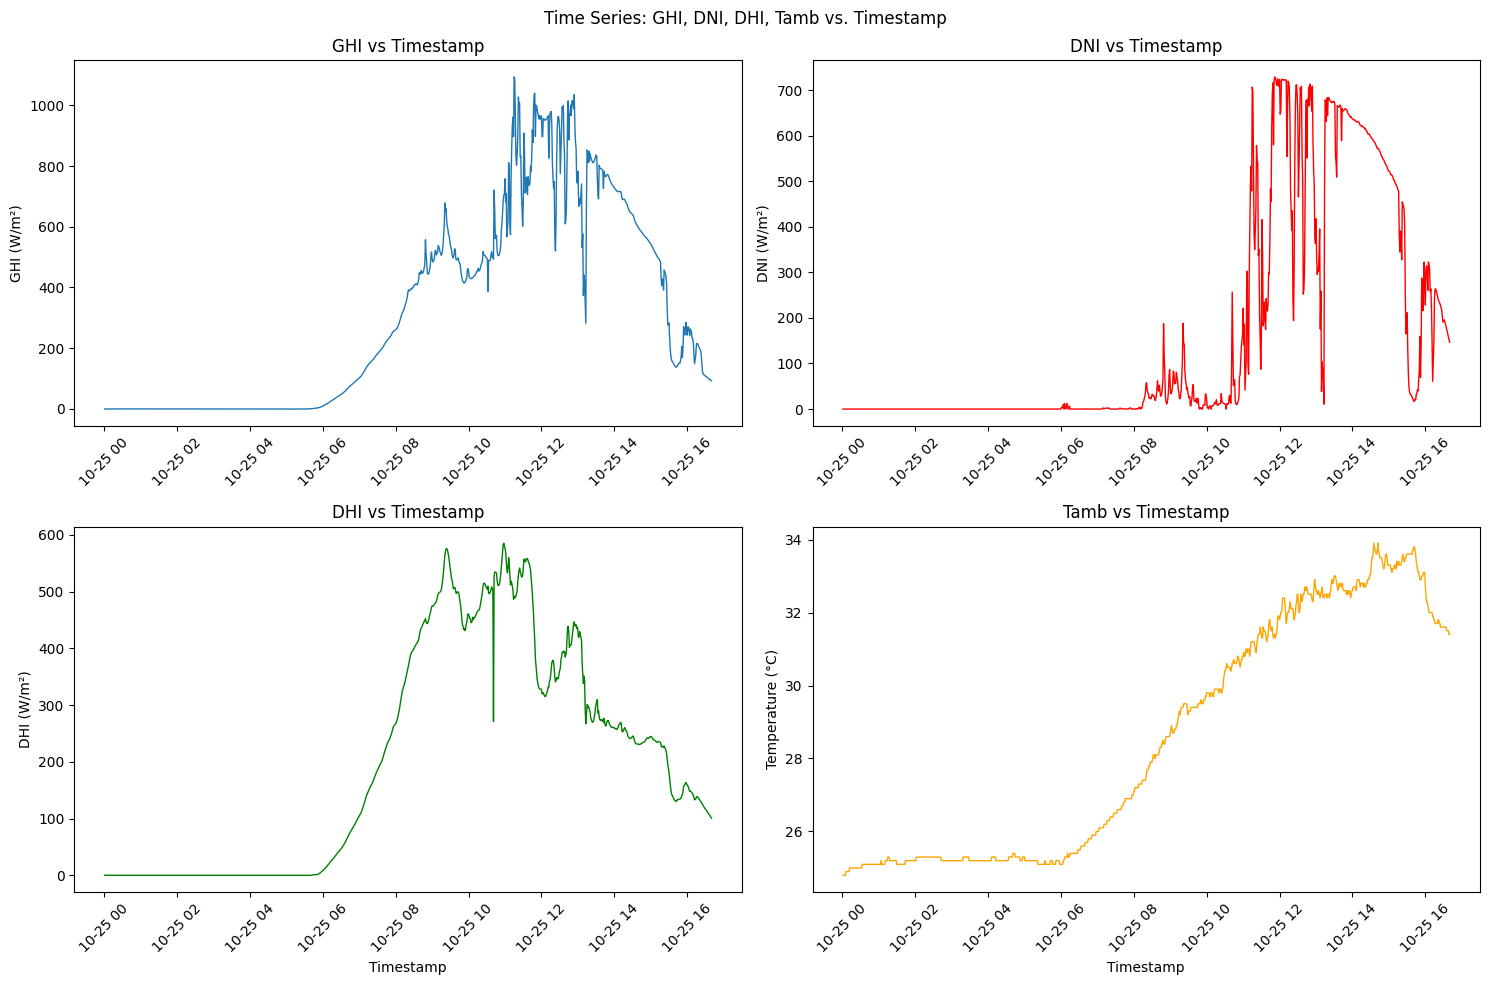


 PATTERNS & ANOMALIES
DAILY TRENDS (Peak Hours):
  GHI: Peak at hour 11 (777.1)
  DNI: Peak at hour 12 (441.5)
  DHI: Peak at hour 11 (326.6)
  Tamb: Peak at hour 14 (33.3)

MONTHLY PATTERNS (Best/Worst Months):
  GHI: Best month 2, Worst month 9
  DNI: Best month 11, Worst month 8
  DHI: Best month 3, Worst month 11

ANOMALIES DETECTED:
  GHI spikes (>2 std dev): 32391 occurrences
  Temperature spikes (>2 std dev): 16305 occurrences


In [13]:
# TIME SERIES ANALYSIS - EXACTLY AS SPECIFIED
print("TIME SERIES ANALYSIS")
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
df_clean['Month'] = df_clean['Timestamp'].dt.month


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time Series: GHI, DNI, DHI, Tamb vs. Timestamp')

axes[0,0].plot(df_clean['Timestamp'][:1000], df_clean['GHI'][:1000], linewidth=1)
axes[0,0].set_title('GHI vs Timestamp')
axes[0,0].set_ylabel('GHI (W/m²)')
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(df_clean['Timestamp'][:1000], df_clean['DNI'][:1000], linewidth=1, color='red')
axes[0,1].set_title('DNI vs Timestamp')
axes[0,1].set_ylabel('DNI (W/m²)')
axes[0,1].tick_params(axis='x', rotation=45)

axes[1,0].plot(df_clean['Timestamp'][:1000], df_clean['DHI'][:1000], linewidth=1, color='green')
axes[1,0].set_title('DHI vs Timestamp')
axes[1,0].set_ylabel('DHI (W/m²)')
axes[1,0].set_xlabel('Timestamp')
axes[1,0].tick_params(axis='x', rotation=45)

axes[1,1].plot(df_clean['Timestamp'][:1000], df_clean['Tamb'][:1000], linewidth=1, color='orange')
axes[1,1].set_title('Tamb vs Timestamp')
axes[1,1].set_ylabel('Temperature (°C)')
axes[1,1].set_xlabel('Timestamp')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n PATTERNS & ANOMALIES")

print("DAILY TRENDS (Peak Hours):")
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    hourly_avg = df_clean.groupby('Hour')[col].mean()
    peak_hour = hourly_avg.idxmax()
    peak_value = hourly_avg.max()
    print(f"  {col}: Peak at hour {peak_hour} ({peak_value:.1f})")

print("\nMONTHLY PATTERNS (Best/Worst Months):")
for col in ['GHI', 'DNI', 'DHI']:
    monthly_avg = df_clean.groupby('Month')[col].mean()
    best_month = monthly_avg.idxmax()
    worst_month = monthly_avg.idxmin()
    print(f"  {col}: Best month {best_month}, Worst month {worst_month}")

print("\nANOMALIES DETECTED:")
ghi_std = df_clean['GHI'].std()
high_ghi = (df_clean['GHI'] > df_clean['GHI'].mean() + 2*ghi_std).sum()
print(f"  GHI spikes (>2 std dev): {high_ghi} occurrences")

temp_std = df_clean['Tamb'].std()
high_temp = (df_clean['Tamb'] > df_clean['Tamb'].mean() + 2*temp_std).sum()
print(f"  Temperature spikes (>2 std dev): {high_temp} occurrences")

 CLEANING IMPACT ANALYSIS
Average Sensor Readings - Cleaning Impact:
                ModA        ModB
Cleaning                        
0         225.661615  218.936860
1         535.186477  532.211744


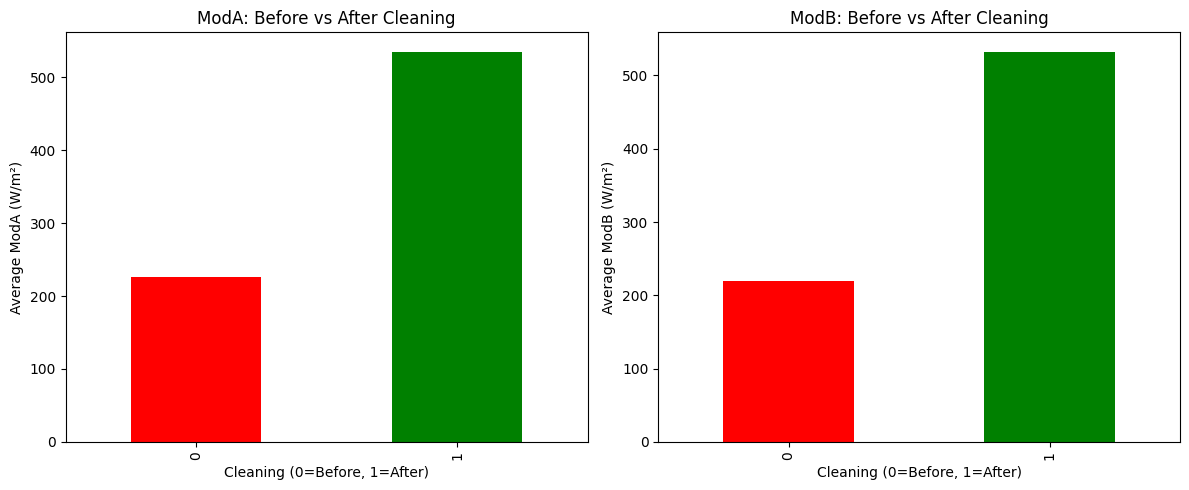


Cleaning Effectiveness:
ModA improvement: 137.2%
ModB improvement: 143.1%


In [14]:
# CLEANING IMPACT ANALYSIS
print(" CLEANING IMPACT ANALYSIS")
cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()

print("Average Sensor Readings - Cleaning Impact:")
print(cleaning_impact)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cleaning_impact['ModA'].plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('ModA: Before vs After Cleaning')
axes[0].set_ylabel('Average ModA (W/m²)')
axes[0].set_xlabel('Cleaning (0=Before, 1=After)')  
cleaning_impact['ModB'].plot(kind='bar', ax=axes[1], color=['red', 'green'])
axes[1].set_title('ModB: Before vs After Cleaning')
axes[1].set_ylabel('Average ModB (W/m²)')
axes[1].set_xlabel('Cleaning (0=Before, 1=After)')

plt.tight_layout()
plt.show()

if 0 in cleaning_impact.index and 1 in cleaning_impact.index:
    moda_improvement = ((cleaning_impact.loc[1, 'ModA'] - cleaning_impact.loc[0, 'ModA']) / cleaning_impact.loc[0, 'ModA']) * 100
    modb_improvement = ((cleaning_impact.loc[1, 'ModB'] - cleaning_impact.loc[0, 'ModB']) / cleaning_impact.loc[0, 'ModB']) * 100
    print(f"\nCleaning Effectiveness:")
    print(f"ModA improvement: {moda_improvement:.1f}%")
    print(f"ModB improvement: {modb_improvement:.1f}%")
else:
    print("\nNote: Cleaning flag may not have both values (0 and 1)")

CORRELATION & RELATIONSHIP ANALYSIS
1. Correlation Heatmap


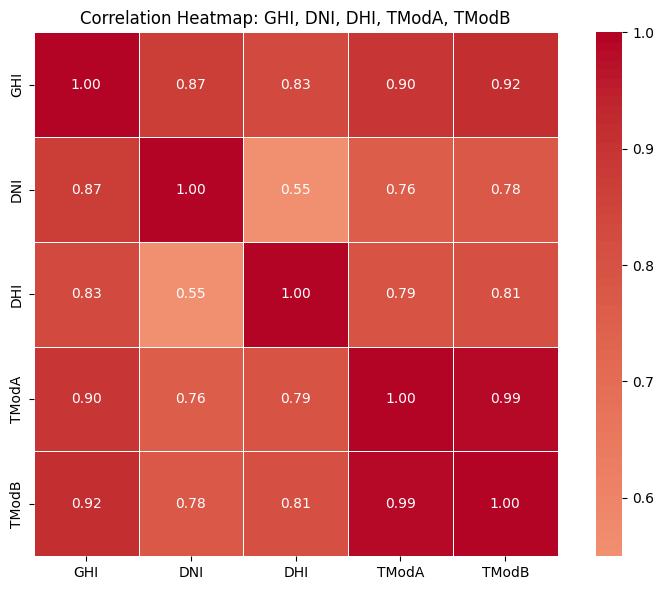

2. Scatter Plots


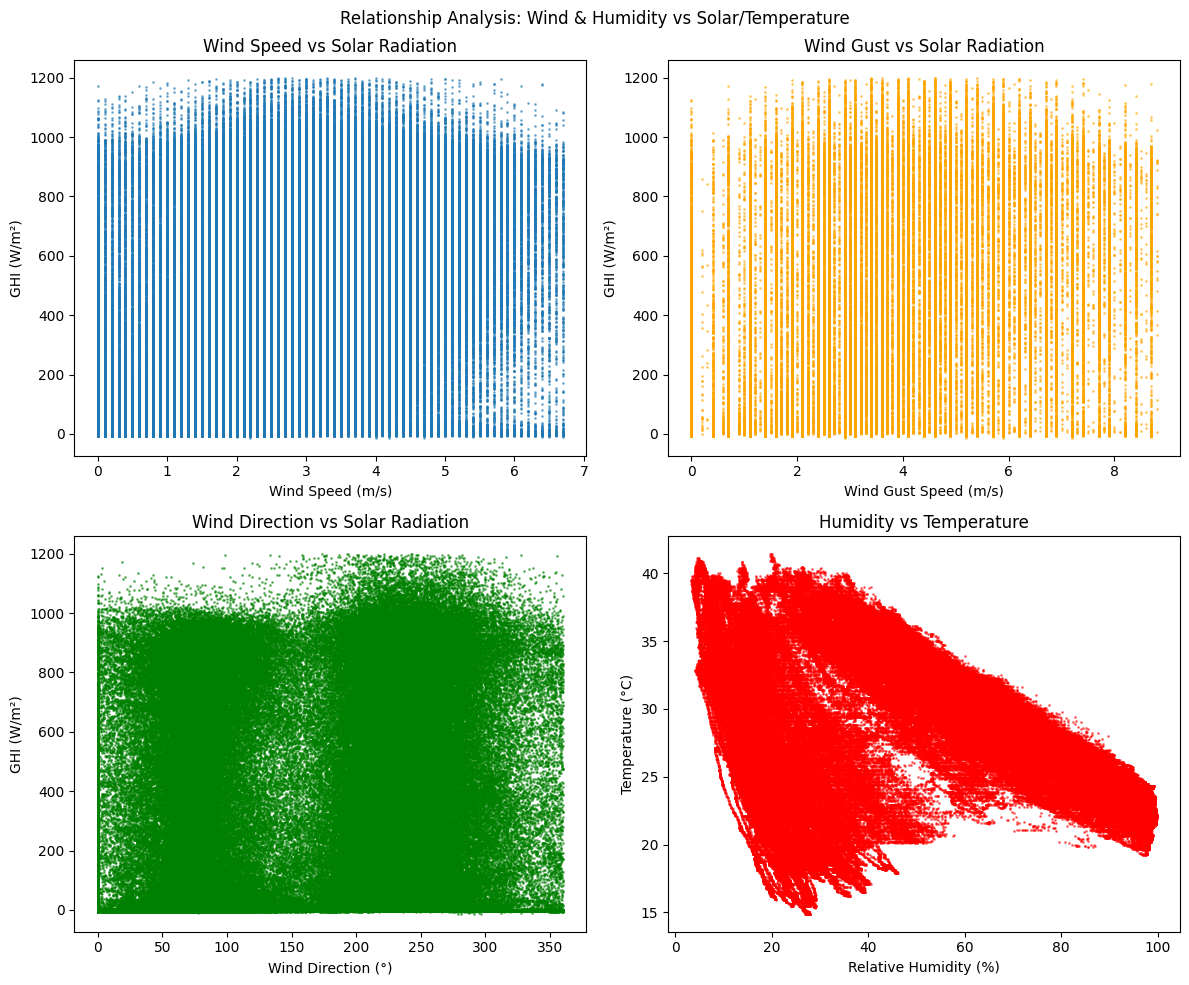

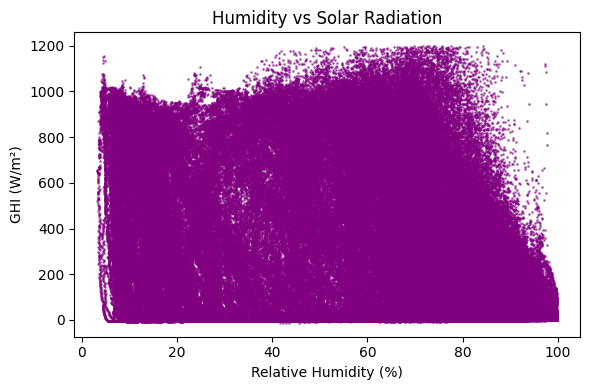

Correlation analysis complete!


In [15]:
# CORRELATION & RELATIONSHIP ANALYSIS
print("CORRELATION & RELATIONSHIP ANALYSIS")

print("1. Correlation Heatmap")
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
available_corr_cols = [col for col in corr_columns if col in df_clean.columns]

plt.figure(figsize=(8, 6))
correlation_matrix = df_clean[available_corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: GHI, DNI, DHI, TModA, TModB')
plt.tight_layout()
plt.show()

print("2. Scatter Plots")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Relationship Analysis: Wind & Humidity vs Solar/Temperature')

axes[0,0].scatter(df_clean['WS'], df_clean['GHI'], alpha=0.5, s=1)
axes[0,0].set_xlabel('Wind Speed (m/s)')
axes[0,0].set_ylabel('GHI (W/m²)')
axes[0,0].set_title('Wind Speed vs Solar Radiation')

axes[0,1].scatter(df_clean['WSgust'], df_clean['GHI'], alpha=0.5, s=1, color='orange')
axes[0,1].set_xlabel('Wind Gust Speed (m/s)')
axes[0,1].set_ylabel('GHI (W/m²)')
axes[0,1].set_title('Wind Gust vs Solar Radiation')

if 'WD' in df_clean.columns:
    axes[1,0].scatter(df_clean['WD'], df_clean['GHI'], alpha=0.5, s=1, color='green')
    axes[1,0].set_xlabel('Wind Direction (°)')
    axes[1,0].set_ylabel('GHI (W/m²)')
    axes[1,0].set_title('Wind Direction vs Solar Radiation')
else:
    axes[1,0].text(0.5, 0.5, 'WD column not available', ha='center', va='center')
    axes[1,0].set_title('Wind Direction vs Solar Radiation')

axes[1,1].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5, s=1, color='red')
axes[1,1].set_xlabel('Relative Humidity (%)')
axes[1,1].set_ylabel('Temperature (°C)')
axes[1,1].set_title('Humidity vs Temperature')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5, s=1, color='purple')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.title('Humidity vs Solar Radiation')
plt.tight_layout()
plt.show()

print("Correlation analysis complete!")

WIND & DISTRIBUTION ANALYSIS
1. Distribution Histograms


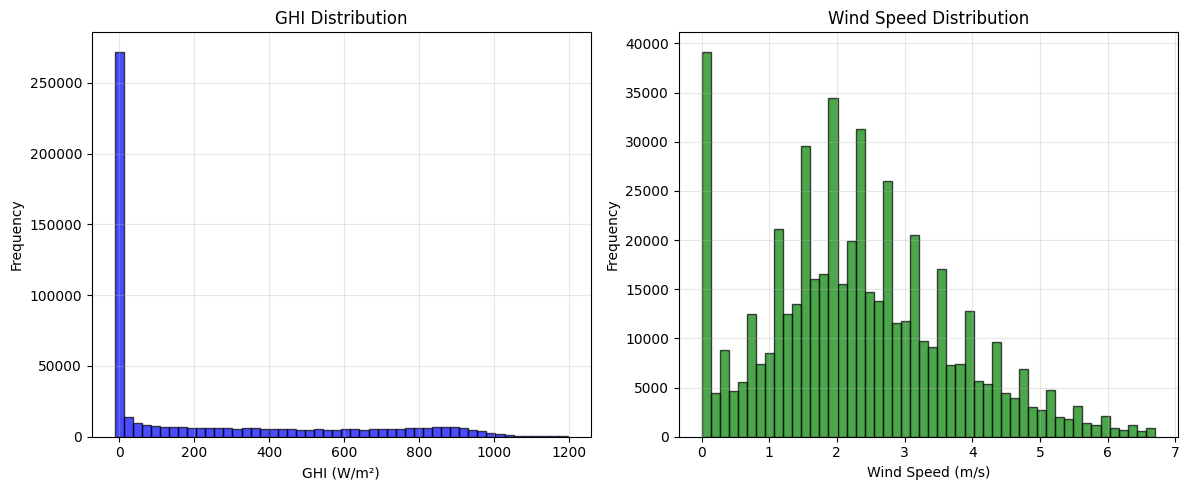

2. Wind Direction Analysis


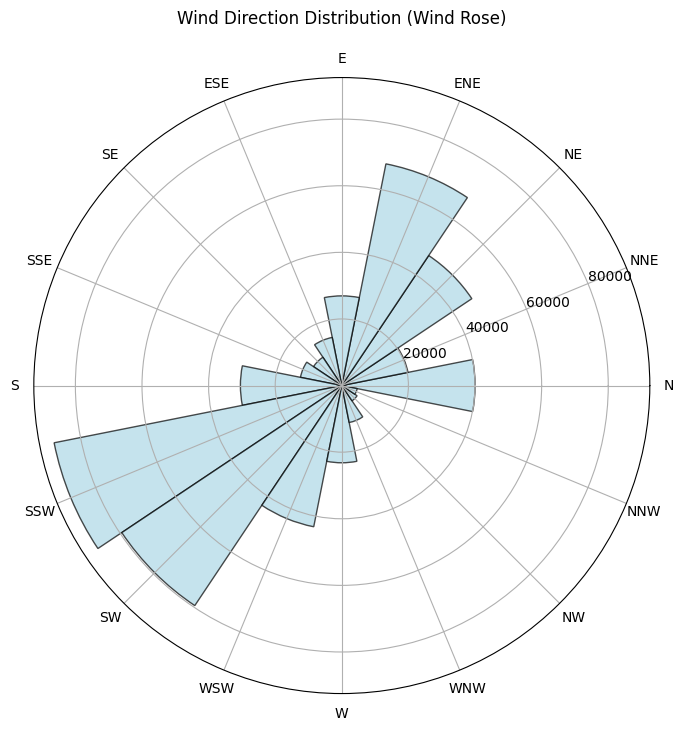

Most common wind directions:
WD_bin
N      40037
NNE    20249
NE     46953
ENE    67873
E      26930
Name: count, dtype: int64


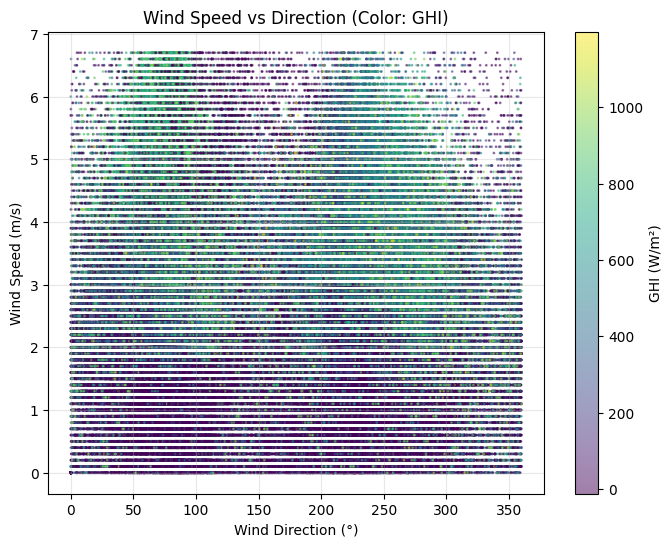

Wind & distribution analysis complete!


In [16]:
# WIND & DISTRIBUTION ANALYSIS
print("WIND & DISTRIBUTION ANALYSIS")
print("1. Distribution Histograms")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].hist(df_clean['GHI'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('GHI (W/m²)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('GHI Distribution')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_clean['WS'].dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Wind Speed (m/s)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Wind Speed Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("2. Wind Direction Analysis")

if 'WD' in df_clean.columns:
    
    wind_bins = np.linspace(0, 360, 17)
    wind_labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 
                   'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    
    df_clean['WD_bin'] = pd.cut(df_clean['WD'], bins=wind_bins, labels=wind_labels, include_lowest=True)
    
    
    wind_counts = df_clean['WD_bin'].value_counts().sort_index()
    

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    
    theta = np.linspace(0, 2*np.pi, len(wind_counts), endpoint=False)
    widths = 2*np.pi / len(wind_counts)
    
    bars = ax.bar(theta, wind_counts.values, width=widths, alpha=0.7, 
                  color='lightblue', edgecolor='black')
    
    ax.set_xticks(theta)
    ax.set_xticklabels(wind_counts.index)
    ax.set_title('Wind Direction Distribution (Wind Rose)', pad=20)
    plt.show()
    
    print("Most common wind directions:")
    print(wind_counts.head())
else:
    print("WD column not available for wind rose plot")


if 'WD' in df_clean.columns:
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df_clean['WD'], df_clean['WS'], 
                         c=df_clean['GHI'], alpha=0.5, cmap='viridis', s=1)
    plt.colorbar(scatter, label='GHI (W/m²)')
    plt.xlabel('Wind Direction (°)')
    plt.ylabel('Wind Speed (m/s)')
    plt.title('Wind Speed vs Direction (Color: GHI)')
    plt.grid(True, alpha=0.3)
    plt.show()

print("Wind & distribution analysis complete!")

TEMPERATURE ANALYSIS
1. Humidity Influence Analysis


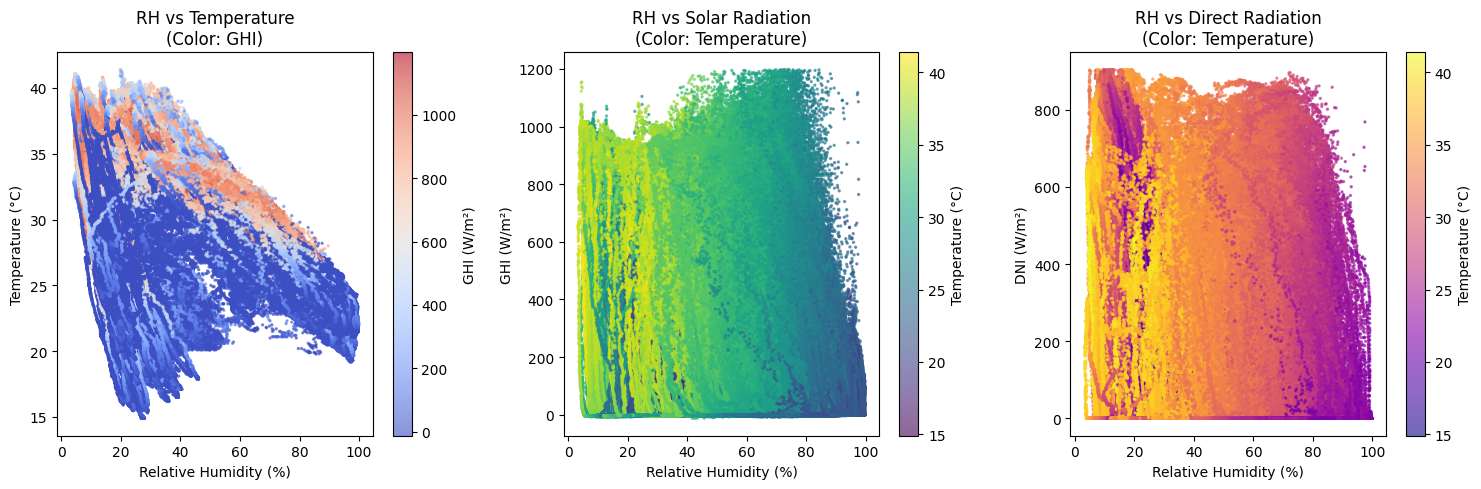

2. Correlation Analysis
Correlation between RH and Temperature: -0.400
Correlation between RH and GHI: -0.260
Correlation between RH and DNI: -0.319
3. Analysis by Humidity Levels

Average Values by Humidity Level:
                  Tamb           GHI             DNI        
                  mean   std    mean     std    mean     std
RH_Level                                                    
Low (0-30%)      28.73  6.05  288.15  346.62  227.41  292.63
Medium (30-60%)  30.47  4.89  305.33  360.33  197.27  262.24
High (60-100%)   25.96  2.62  162.01  269.72   82.58  189.20


C:\Users\arwa\AppData\Local\Temp\ipykernel_14020\2485266071.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  humidity_analysis = df_clean.groupby('RH_Level').agg({


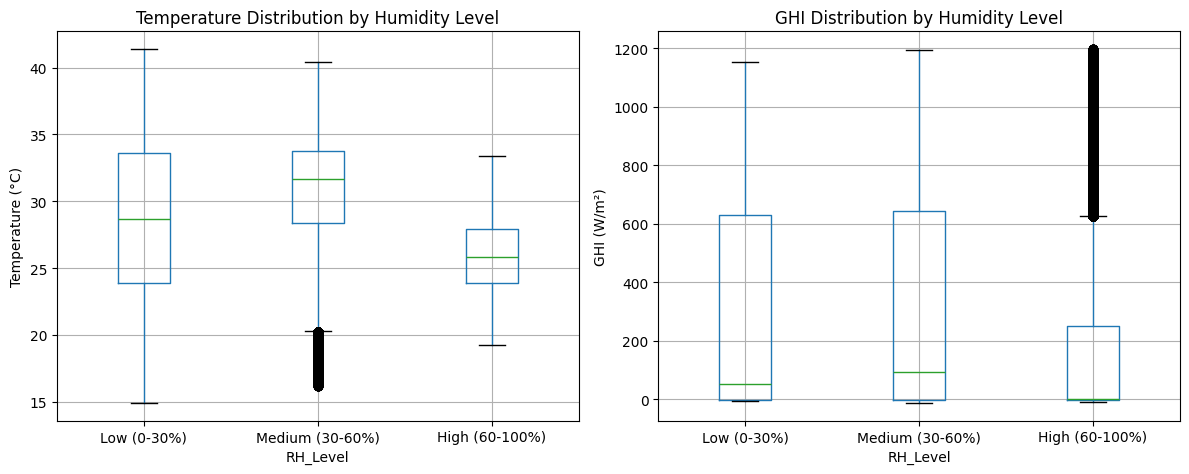

4. Key Insights:
- Temperature-Humidity Relationship: -0.400 correlation
  → Strong negative correlation: Higher humidity = Lower temperatures
- Solar-Humidity Relationship: -0.260 correlation
  → Weak correlation: Humidity has minimal direct effect on solar radiation

Temperature analysis complete!


In [17]:
# TEMPERATURE ANALYSIS
print("TEMPERATURE ANALYSIS")

print("1. Humidity Influence Analysis")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = axes[0].scatter(df_clean['RH'], df_clean['Tamb'], 
                          c=df_clean['GHI'], alpha=0.6, cmap='coolwarm', s=2)
axes[0].set_xlabel('Relative Humidity (%)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('RH vs Temperature\n(Color: GHI)')
plt.colorbar(scatter1, ax=axes[0], label='GHI (W/m²)')

scatter2 = axes[1].scatter(df_clean['RH'], df_clean['GHI'], 
                          c=df_clean['Tamb'], alpha=0.6, cmap='viridis', s=2)
axes[1].set_xlabel('Relative Humidity (%)')
axes[1].set_ylabel('GHI (W/m²)')
axes[1].set_title('RH vs Solar Radiation\n(Color: Temperature)')
plt.colorbar(scatter2, ax=axes[1], label='Temperature (°C)')

scatter3 = axes[2].scatter(df_clean['RH'], df_clean['DNI'], 
                          c=df_clean['Tamb'], alpha=0.6, cmap='plasma', s=2)
axes[2].set_xlabel('Relative Humidity (%)')
axes[2].set_ylabel('DNI (W/m²)')
axes[2].set_title('RH vs Direct Radiation\n(Color: Temperature)')
plt.colorbar(scatter3, ax=axes[2], label='Temperature (°C)')

plt.tight_layout()
plt.show()

print("2. Correlation Analysis")
temp_humidity_corr = df_clean['RH'].corr(df_clean['Tamb'])
ghi_humidity_corr = df_clean['RH'].corr(df_clean['GHI'])
dni_humidity_corr = df_clean['RH'].corr(df_clean['DNI'])

print(f"Correlation between RH and Temperature: {temp_humidity_corr:.3f}")
print(f"Correlation between RH and GHI: {ghi_humidity_corr:.3f}")
print(f"Correlation between RH and DNI: {dni_humidity_corr:.3f}")

print("3. Analysis by Humidity Levels")
df_clean['RH_Level'] = pd.cut(df_clean['RH'], bins=[0, 30, 60, 100], 
                              labels=['Low (0-30%)', 'Medium (30-60%)', 'High (60-100%)'])

humidity_analysis = df_clean.groupby('RH_Level').agg({
    'Tamb': ['mean', 'std'],
    'GHI': ['mean', 'std'],
    'DNI': ['mean', 'std']
}).round(2)

print("\nAverage Values by Humidity Level:")
print(humidity_analysis)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


df_clean.boxplot(column='Tamb', by='RH_Level', ax=axes[0])
axes[0].set_title('Temperature Distribution by Humidity Level')
axes[0].set_ylabel('Temperature (°C)')


df_clean.boxplot(column='GHI', by='RH_Level', ax=axes[1])
axes[1].set_title('GHI Distribution by Humidity Level')
axes[1].set_ylabel('GHI (W/m²)')

plt.suptitle('')  
plt.tight_layout()
plt.show()


print("4. Key Insights:")
print(f"- Temperature-Humidity Relationship: {temp_humidity_corr:.3f} correlation")
if temp_humidity_corr < -0.3:
    print("  → Strong negative correlation: Higher humidity = Lower temperatures")
elif temp_humidity_corr > 0.3:
    print("  → Strong positive correlation: Higher humidity = Higher temperatures")
else:
    print("  → Weak correlation: Humidity has minimal direct effect on temperature")

print(f"- Solar-Humidity Relationship: {ghi_humidity_corr:.3f} correlation")
if ghi_humidity_corr < -0.3:
    print("  → Strong negative correlation: Higher humidity = Lower solar radiation")
elif ghi_humidity_corr > 0.3:
    print("  → Strong positive correlation: Higher humidity = Higher solar radiation")
else:
    print("  → Weak correlation: Humidity has minimal direct effect on solar radiation")

print("\nTemperature analysis complete!")

BUBBLE CHART ANALYSIS
1. GHI vs Temperature (Bubble Size = RH)


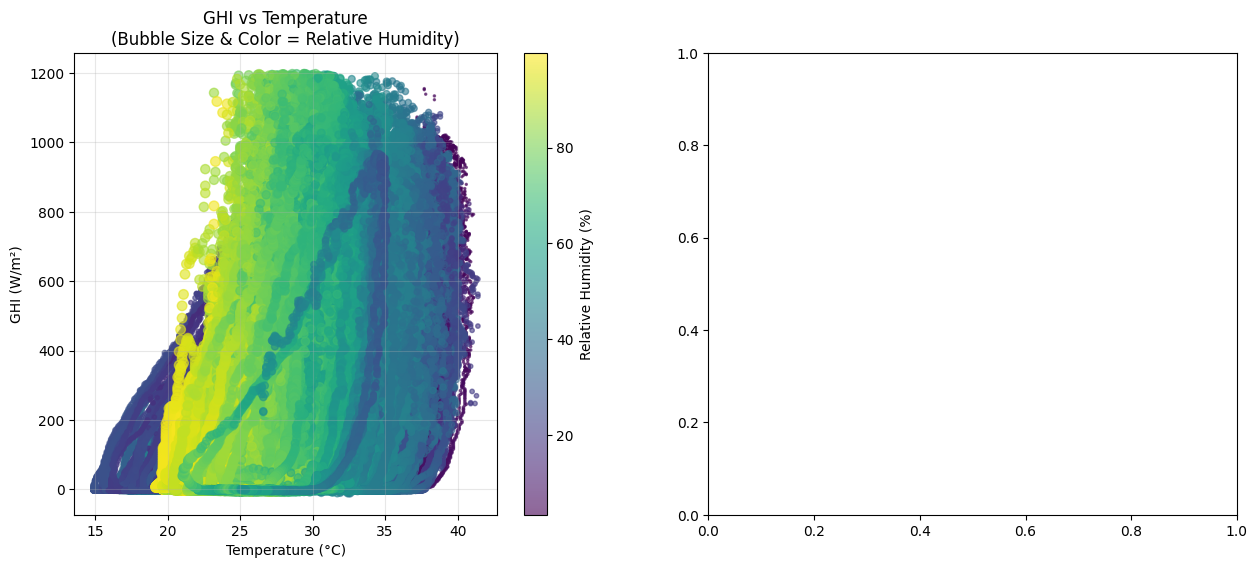

In [18]:
# BUBBLE CHART
print("BUBBLE CHART ANALYSIS")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))


print("1. GHI vs Temperature (Bubble Size = RH)")
scatter1 = axes[0].scatter(df_clean['Tamb'], df_clean['GHI'], 
                          s=df_clean['RH']/2, 
                          c=df_clean['RH'], alpha=0.6, cmap='viridis')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('GHI (W/m²)')
axes[0].set_title('GHI vs Temperature\n(Bubble Size & Color = Relative Humidity)')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Relative Humidity (%)')


axes[0].grid(True, alpha=0.3)